<a href="https://colab.research.google.com/github/abccodes/Treehacks2024/blob/co-lab/Copy_of_Treehacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounting Co-Lab To Drive

In [22]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
import pandas as pd
import numpy as np
import os
import cv2
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, MaxPool2D
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


[link text](https://)Importing Pandas Linking to CSV file.

@dev need to configure filepath to match your google drive. If shared file right click and click add shortcut to myDrive

In [24]:

csv_path = "HAM10000_metadata.csv"
data_path = '/content/drive/MyDrive/HAM10000_images_part_1/'
# data_path = 'HAM10000_images_part_1/'
train_path = data_path + "train_500/"
# train_path = 'HAM10000_images_part_1/'
test_path = data_path + "test_500/"
# test_path = 'HAM10000_images_part_2/'


df = pd.read_csv(data_path+csv_path)
# df = pd.read_csv(csv_path)


In [25]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

lesion_ID_dict = {
    'nv': 0,
    'mel': 1,
    'bkl': 2,
    'bcc': 3,
    'akiec': 4,
    'vasc': 5,
    'df': 6
}

Displaying CSV

In [26]:
df.head()


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [27]:
def load_images_from_folder(folder, df, image_size=(224, 224)):
    images = []
    labels = []
    # Adjust the lesion_ID_dict according to your specific classes if necessary
    lesion_ID_dict = {'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3, 'akiec': 4, 'vasc': 5, 'df': 6}

    for filename in os.listdir(folder):
        image_id = filename.split('.')[0]
        if image_id in df['image_id'].values:
            img_path = os.path.join(folder, filename)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            img = cv2.resize(img, image_size)
            img = preprocess_input(img)  # Preprocess for ResNet50

            # Extract label for current image
            label = df.loc[df['image_id'] == image_id, 'dx'].values[0]
            label = lesion_ID_dict[label]  # Convert label to numeric

            images.append(img)
            labels.append(label)

    return np.array(images), to_categorical(labels, num_classes=len(lesion_ID_dict))


In [28]:
# Load dataset
train_images, train_labels = load_images_from_folder(train_path, df)
test_images, test_labels = load_images_from_folder(test_path, df)


Checking the distribution of labels (skin lesion types) in both the training and test datasets.

In [29]:
# Assuming 'df' is your complete DataFrame and contains labels for both training and test images
# And assuming 'image_ids' from both training and test sets have been extracted during loading
# train_image_ids = [f.split('.')[0] for f in os.listdir(data_path + "train_500/")]
# test_image_ids = [f.split('.')[0] for f in os.listdir(data_path + "test_500/")]
train_image_ids = [f.split('.')[0] for f in os.listdir(train_path)]
test_image_ids = [f.split('.')[0] for f in os.listdir(test_path)]

# Filter 'df' to obtain separate DataFrames for training and test sets
train_df = df[df['image_id'].isin(train_image_ids)]
test_df = df[df['image_id'].isin(test_image_ids)]

# Analyze label distribution
train_label_distribution = train_df['dx'].value_counts()
test_label_distribution = test_df['dx'].value_counts()

print("Training Label Distribution:\n", train_label_distribution)
print("\nTest Label Distribution:\n", test_label_distribution)

Training Label Distribution:
 nv       353
bkl       58
mel       38
bcc       24
akiec     17
vasc       6
df         4
Name: dx, dtype: int64

Test Label Distribution:
 nv       322
mel       78
bkl       51
bcc       19
akiec     13
vasc       9
df         8
Name: dx, dtype: int64


Visualizing the distribution can help understand the balance of classes better.

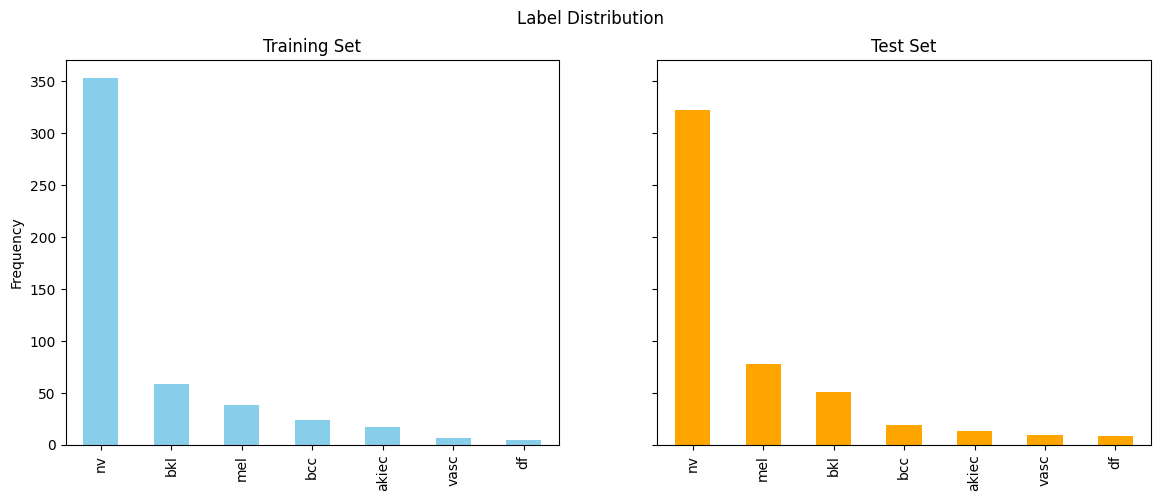

In [30]:
def plot_label_distribution(train_labels, test_labels, title="Label Distribution"):
    fig, ax = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

    train_labels.plot(kind='bar', ax=ax[0], color='skyblue')
    ax[0].set_title("Training Set")
    ax[0].set_ylabel("Frequency")

    test_labels.plot(kind='bar', ax=ax[1], color='orange')
    ax[1].set_title("Test Set")

    plt.suptitle(title)
    plt.show()

plot_label_distribution(train_label_distribution, test_label_distribution)

Can compare features like age, gender, and lesion location between the training and test sets, you can calculate and visualize their distributions. Here's how to do it for the 'age' feature as an example:


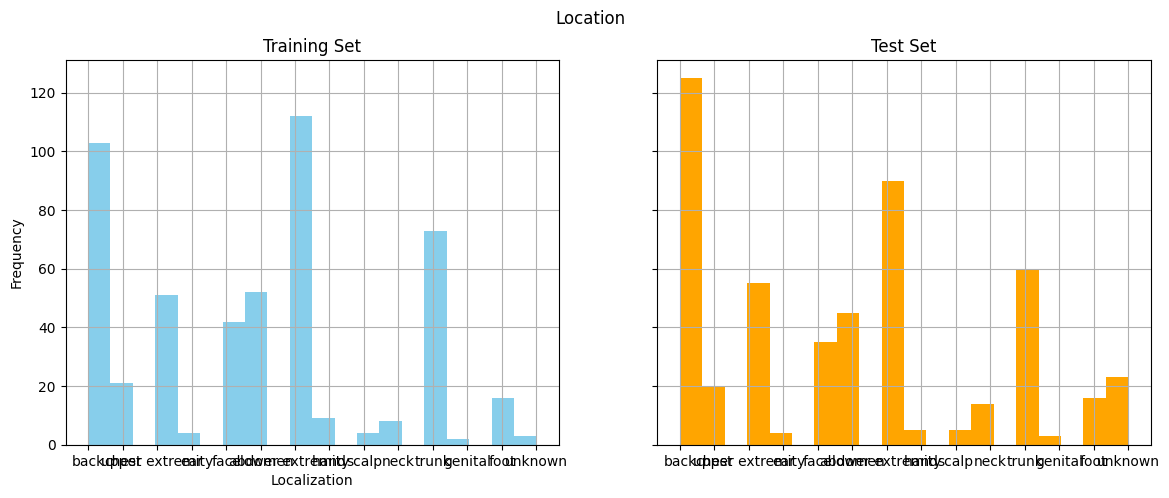

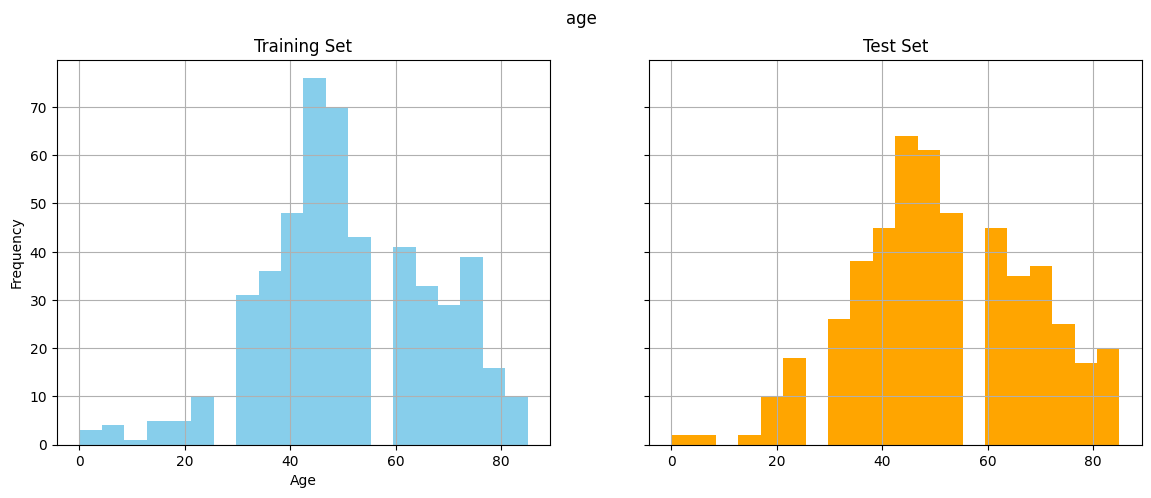

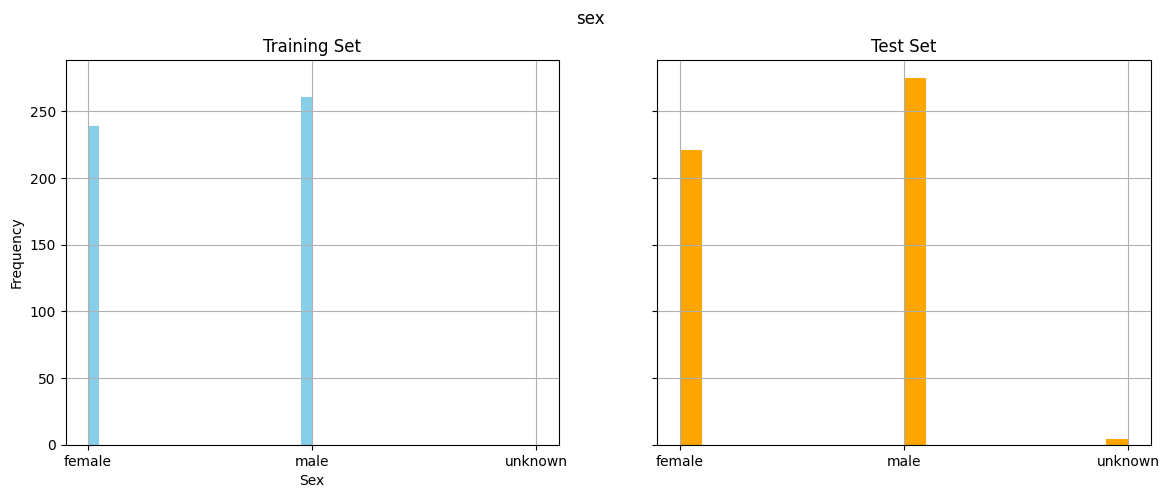

In [31]:
def plot_feature_distribution(train_df, test_df, feature, title="Feature Distribution"):
    fig, ax = plt.subplots(1, 2, figsize=(14, 5), sharex=True, sharey=True)

    train_df[feature].hist(bins=20, ax=ax[0], color='skyblue')
    ax[0].set_title("Training Set")
    ax[0].set_xlabel(feature.capitalize())
    ax[0].set_ylabel("Frequency")

    test_df[feature].hist(bins=20, ax=ax[1], color='orange')
    ax[1].set_title("Test Set")

    plt.suptitle(title)
    plt.show()

# Plotting the distribution of ages in the training and test sets
plot_feature_distribution(train_df, test_df, 'localization', "Location")
plot_feature_distribution(train_df, test_df, 'age', "age")
plot_feature_distribution(train_df, test_df, 'sex', "sex")

In [32]:
# Load the base ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(lesion_ID_dict), activation='softmax')(x)  # Assuming lesion_ID_dict is defined as before

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Note: No augmentation for the test data
test_datagen = ImageDataGenerator()

# Apply preprocessing and augmentation to the training data
train_generator = train_datagen.flow(train_images, train_labels, batch_size=32)

# Only apply preprocessing to the test data
test_generator = test_datagen.flow(test_images, test_labels, batch_size=32, shuffle=False)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_images) // 32,
    epochs=10,
    validation_data=test_generator,
    validation_steps=len(test_images) // 32
)

Epoch 1/10
15/15 [==============================] - 178s 12s/step - loss: 1.2690 - accuracy: 0.6688 - val_loss: 1.1042 - val_accuracy: 0.6479
Epoch 2/10
15/15 [==============================] - 230s 16s/step - loss: 0.7819 - accuracy: 0.7564 - val_loss: 1.0126 - val_accuracy: 0.6708
Epoch 3/10
15/15 [==============================] - 239s 17s/step - loss: 0.7084 - accuracy: 0.7585 - val_loss: 0.9445 - val_accuracy: 0.6938
Epoch 4/10
15/15 [==============================] - 228s 16s/step - loss: 0.5879 - accuracy: 0.7949 - val_loss: 0.9571 - val_accuracy: 0.6854
Epoch 5/10
15/15 [==============================] - 170s 12s/step - loss: 0.5291 - accuracy: 0.8205 - val_loss: 0.9065 - val_accuracy: 0.6958
Epoch 6/10
15/15 [==============================] - 229s 16s/step - loss: 0.5132 - accuracy: 0.8120 - val_loss: 0.9179 - val_accuracy: 0.6812
Epoch 7/10
15/15 [==============================] - 167s 11s/step - loss: 0.4698 - accuracy: 0.8632 - val_loss: 0.9435 - val_accuracy: 0.6771
Epoch 

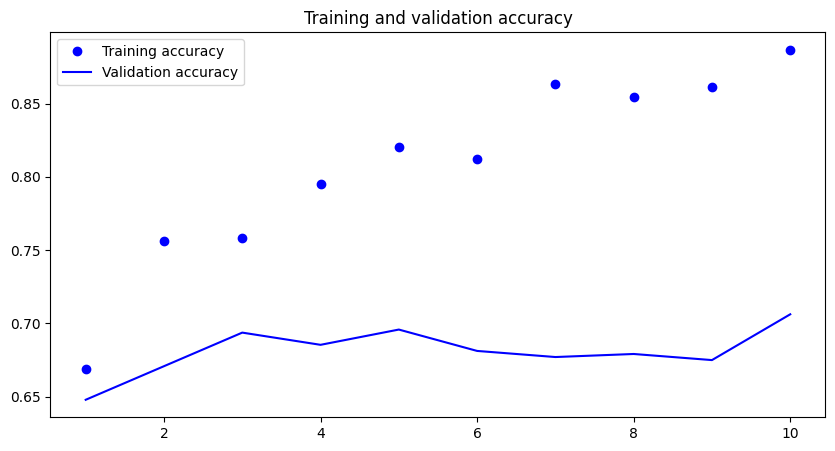

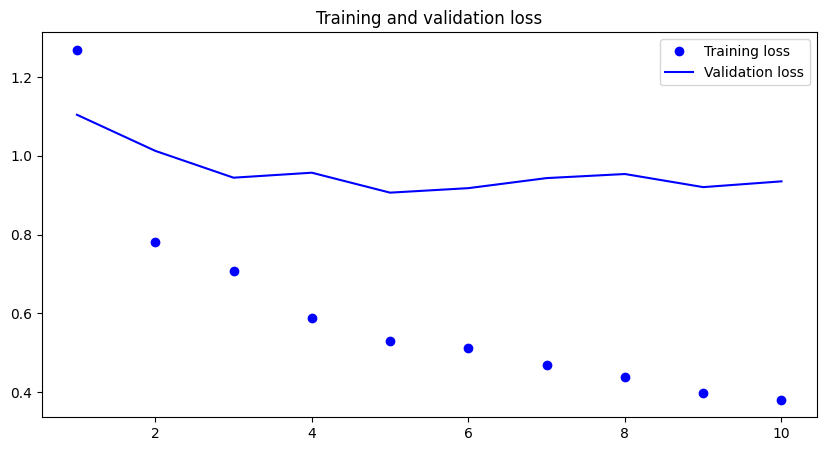

In [35]:
# The first plot shows the training and validation accuracy as a function of epochs.
# The second plot shows the training and validation loss as a function of epochs.
# Assuming 'history' is the return value from the model.fit() call
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot training and validation accuracy per epoch
plt.figure(figsize=(10, 5))
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure(figsize=(10, 5))
# Plot training and validation loss per epoch
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [33]:
model.save('skin.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
